# Recommendation

1. 推薦系統的種類
    - collabrative(協同推薦)
    
    ![collabrative](./imgs/collabrative.jpg)
    
    - content-based(內容推薦)
    
    ![content-based](./imgs/content-based.jpg)


from [quora](https://www.quora.com/What-is-the-difference-between-content-based-filtering-and-collaborative-filtering)

## IMPORT & DATA

In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
import xgboost
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

In [2]:
df_articles = pd.read_csv('shared_articles.csv')
df_articles = df_articles[df_articles['eventType'] == 'CONTENT SHARED']
df_articles.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [3]:
df_interactions = pd.read_csv('users_interactions.csv')
df_interactions.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


## Preprocessing

In [4]:
set(df_interactions['eventType'])

{'BOOKMARK', 'COMMENT CREATED', 'FOLLOW', 'LIKE', 'VIEW'}

In [5]:
event_type_strength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

# 請將eventType按照event_type_strength進行評分
#=============your works starts===============#
df_interactions['eventStrength'] = df_interactions['eventType'].apply(lambda x: event_type_strength[x])
#==============your works ends================#

print("平均互動分數:", np.average(df_interactions['eventStrength']))
# 平均互動分數: 1.2362885828078327

平均互動分數: 1.2362885828078327


在推薦系統中，有一個很常見的問題，稱為***cold-start***。因為，很多使用者並沒有真正的根產品產生任何互動，所以並沒有辦法從資料及當中了解到他們偏好。因此，這邊我們將少於五個interactions的user刪掉。

In [7]:
# 計算出每個使用者有對幾項不同的商品進行互動(hint: 以['personId', 'contentId']進行groupby取出現次數，再用'personId'進行groupby取出現次數)
# 篩選掉互動商品數小於五次的使用者(hint: return list)
#=============your works starts===============#
df_users_interactions_count = df_interactions.groupby(['personId', 'contentId']).size().groupby('personId').size()
users_with_enough_interactions = df_users_interactions_count[df_users_interactions_count>5].index.tolist()
#==============your works ends================#

print("平均對?個商品有互動: ", np.average(df_users_interactions_count), "次")
print("使用者個數: ",  len(df_users_interactions_count))
print("互動大於5次使用者個數", len(users_with_enough_interactions))
# 平均互動次數:  21.482849604221634 次
# 使用者個數:  1895
# 互動大於5次使用者個數 1140

平均對?個商品有互動:  21.482849604221634 次
使用者個數:  1895
互動大於5次使用者個數 1041


In [8]:
# 找出df_interactions中personId在users_with_enough_interactions當中的row
#=============your works starts===============#
df_interactions_from_selected_users = df_interactions[df_interactions['personId'].isin(users_with_enough_interactions)]
#==============your works ends================#

print('總互動比數:', len(df_interactions))
print('互動次數大於五用戶總互動比數:', len(df_interactions_from_selected_users))
# 總互動比數: 72312
# 互動次數大於五用戶總互動比數: 69868

總互動比數: 72312
互動次數大於五用戶總互動比數: 69081


In [9]:
def smooth_user_preference(x):
    # 請先+epsilon再取log，以平滑互動分數
    #=============your works starts===============#
    logged = np.log(1+x)
    #==============your works ends================#
    return logged


print(smooth_user_preference(1))
print(smooth_user_preference(2))
print(smooth_user_preference(3))
# 0.6931471805599453
# 1.0986122886681098
# 1.3862943611198906

0.6931471805599453
1.0986122886681098
1.3862943611198906


In [10]:
# 計算使用者對於個別文章喜愛的加總
# 並透過上面的smooth_user_preference使其平滑
#=============your works starts===============#
df_interactions_full_no_smooth = df_interactions_from_selected_users.groupby(['personId', 'contentId'])['eventStrength'].sum()
df_interactions_full = df_interactions_full_no_smooth.apply(smooth_user_preference).reset_index()
#==============your works ends================#

print('平均喜好分數(未平滑)', np.average(df_interactions_full_no_smooth), np.std(df_interactions_full_no_smooth))
print('平均喜好分數(平滑)', np.average(df_interactions_full['eventStrength']), np.std(df_interactions_full['eventStrength']))
# 平均喜好分數(未平滑) 2.214954226972843
# 平均喜好分數(平滑) 1.015265936675581

平均喜好分數(未平滑) 2.220261065499469 2.8380849823986174
平均喜好分數(平滑) 1.0164614716457134 0.4766906042612754


## 評價
### 基礎知識

|     col    | Retrieved         | Non Retrieved      |
|------------|-------------------|--------------------|
| Relevant   | True Positive(TP) | False Negative(TN) |
| Irrelevant | False Postive(FP) | True Negative(TN)  |

### 解釋
1. Precision at K

$$ Precision={|Relevant \cap Retrieved| \over |Retrieved|}={|TP| \over |TP|+|FP|}\quad \quad$$

2. Recall at K

$$ Recall={|Relevant \cap Retrieved| \over |Relevant|}={|TP| \over |TP|+|FN|}\quad \quad$$

3. F measure

    1. 算術平均數

    $$F={P+R \over 2}\quad where \quad P=Precision,\; R=Recall \quad \quad$$

    2. 幾何平均數

    $$F =\cfrac{1}{\alpha  {\cfrac{1}{P}} + (1 - \alpha )  {\cfrac{1}{R}}}= \cfrac{(\beta ^2 +1)PR}{\beta ^2 B +R} \quad where \quad \beta ^2 = \cfrac{1- \alpha}{\alpha}\quad \quad$$
    
    3. $F_\beta$ or $F_1$
    
    $$ F_1 = F_\beta = \cfrac{1}{0.5  {\cfrac{1}{P}} + 0.5 {\cfrac{1}{R}}} = \cfrac{PR}{0.5P+0.5R} = \cfrac{2PR}{P+R}$$

4. R-Precision
5. NDCG
6. MAP

### 注意事項
1. 注意與Accuracy的區別
$$ {|TP|+|TF| \over |TP|+|TN|+|FP|+|FN|} \quad \quad$$

2. [參考資訊](https://goatwang.github.io/2017/04/22/Evaluation-in-Information-Retrieval/)


In [11]:
# ground truth
# 按照personId, eventStrength兩個欄位進行排序
# 找出每一個personId最喜歡的文章排序
# 對應出personId最喜歡的文章的分數(eventStrength)
#=============your works starts===============#
df_interactions_full_sort = df_interactions_full.sort_values(['personId', 'eventStrength'], ascending=False)
df_answer = df_interactions_full_sort.groupby('personId')['contentId'].apply(list).reset_index()
df_answer['score'] = df_interactions_full_sort.groupby('personId')['eventStrength'].apply(list).tolist()
#==============your works ends================#

df_answer.head(5)
# personId	contentId
# 0	-9223121837663643404	{5211673327552264703, -5002383425685129595, -7...
# 1	-9212075797126931087	{-1995591062742965408, 6852597772196653540, -9...
# 2	-9207251133131336884	{-4029704725707465084, -1297580205670251233, -...
# 3	-9199575329909162940	{5293701842202310496, -5002383425685129595, 54...
# 4	-9196668942822132778	{-721732705314803549, -8813724423497152538, -8...

,personId,contentId,score
0,-9223121837663643404,"[-7423191370472335463, 8302949268716967655, -4...","[2.1972245773362196, 1.6094379124341003, 1.386..."
1,-9207251133131336884,"[-4029704725707465084, 7521700660190108859, -9...","[1.8718021769015913, 1.6094379124341003, 1.386..."
2,-9199575329909162940,"[161784308223385549, -5002383425685129595, 543...","[1.3862943611198906, 1.0986122886681098, 1.098..."
3,-9196668942822132778,"[9175693555063886126, -8813724423497152538, -8...","[1.6094379124341003, 0.6931471805599453, 0.693..."
4,-9188188261933657343,"[-7992053163122498177, 3579921471626387620, -2...","[1.3862943611198906, 1.0986122886681098, 0.693..."


## Popularity model (Base Line)

In [12]:
# 以contentId進行groupby，按照每篇文章總分數進行排序
#=============your works starts===============#
df_item_popularity = df_interactions_full.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
#==============your works ends================#

df_item_popularity.head(5).to_dict(orient='record')
# [{'contentId': -4.029704725707465e+18, 'eventStrength': 213.30481497288199},
#  {'contentId': -6.783772548752092e+18, 'eventStrength': 162.03158006500846},
#  {'contentId': -1.3313934239753886e+17, 'eventStrength': 158.05458586966674},
#  {'contentId': -8.208801367848628e+18, 'eventStrength': 136.62458307425328},
#  {'contentId': -6.843047699859122e+18, 'eventStrength': 134.34939619163308}]

[{'contentId': -4029704725707465084, 'eventStrength': 200.3584062639894},
 {'contentId': -6783772548752091658, 'eventStrength': 157.87269698164877},
 {'contentId': -133139342397538859, 'eventStrength': 154.8765320393188},
 {'contentId': -8208801367848627943, 'eventStrength': 133.8519943520135},
 {'contentId': -6843047699859121724, 'eventStrength': 131.17134236128513}]

In [13]:
def popularity_recommend(user_id):
    # 直接回傳分數加總最高的500篇文章
    #=============your works starts===============#
    recommend = df_item_popularity.loc[:500, 'contentId'].values    
    #==============your works ends================#
    return recommend

# 透過apply function使用popularity_recommend到df_interactions_full["personId"]的每一個row上
df_answer['popularity_recommend'] = df_answer["personId"].apply(popularity_recommend)
df_answer.head(5)

,personId,contentId,score,popularity_recommend
0,-9223121837663643404,"[-7423191370472335463, 8302949268716967655, -4...","[2.1972245773362196, 1.6094379124341003, 1.386...","[-4029704725707465084, -6783772548752091658, -..."
1,-9207251133131336884,"[-4029704725707465084, 7521700660190108859, -9...","[1.8718021769015913, 1.6094379124341003, 1.386...","[-4029704725707465084, -6783772548752091658, -..."
2,-9199575329909162940,"[161784308223385549, -5002383425685129595, 543...","[1.3862943611198906, 1.0986122886681098, 1.098...","[-4029704725707465084, -6783772548752091658, -..."
3,-9196668942822132778,"[9175693555063886126, -8813724423497152538, -8...","[1.6094379124341003, 0.6931471805599453, 0.693...","[-4029704725707465084, -6783772548752091658, -..."
4,-9188188261933657343,"[-7992053163122498177, 3579921471626387620, -2...","[1.3862943611198906, 1.0986122886681098, 0.693...","[-4029704725707465084, -6783772548752091658, -..."


In [14]:
def precision_at_k(row, k=10):
    # 計算每一個row的precision_at_k
    #=============your works starts===============#
    precision = len(set(row['popularity_recommend'][:k]) & set(row['contentId'])) / k
    #==============your works ends================#
    return precision

evaluation_result = df_answer.apply(precision_at_k, axis=1)
print("Average Precision At K:", np.average(evaluation_result))
# Average Precision At K: 0.08511873350923484

Average Precision At K: 0.13170028818443807


In [15]:
def recall_at_k(row, k=10):
    # 計算每一個row的recall_at_k
    #=============your works starts===============#
    recall = len(set(row['popularity_recommend'][:k]) & set(row['contentId'])) / len(row['contentId'])
    #==============your works ends================#
    return recall

evaluation_result = df_answer.apply(recall_at_k, axis=1)
print("Average Recall At K:", np.average(evaluation_result))
# Average Recall At K: 0.08730221807976521

Average Recall At K: 0.06241213889960462


In [20]:
%%time
precisions_popularity = []
recalls_popularity = []
for k in range(1, 500, 5):
    # 找出k個retrieved結果下的precision並append到precisions中
    # 找出k個retrieved結果下的recall並append到recalls中
    #=============your works starts===============#
    p_avg = np.average(df_answer.apply(precision_at_k, axis=1, k=k))
    r_avg = np.average(df_answer.apply(recall_at_k, axis=1, k=k))
    precisions_popularity.append(p_avg)
    recalls_popularity.append(r_avg)
    #==============your works ends================#

print(precisions_popularity[:5])
print(recalls_popularity[:5])
# [0.14142480211081795, 0.12163588390501319, 0.1150395778364116, 0.1054089709762533, 0.09931398416886543]
# [0.023556124542213237, 0.034394715562071, 0.043386947980631974, 0.04921683202394738, 0.05832411771369351]

[0.19116234390009607, 0.14457252641690682, 0.12898436817745174, 0.11779538904899135, 0.10914413796258177]
[0.010780201095895696, 0.043732112155061384, 0.06547523762317772, 0.08336457401588314, 0.10100678706462604]
Wall time: 16.2 s


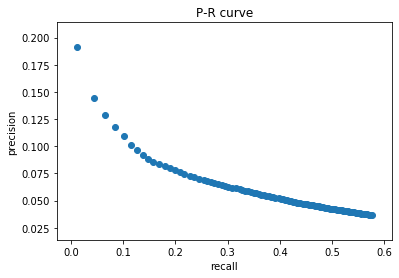

In [21]:
plt.scatter(recalls_popularity, precisions_popularity)
plt.title('P-R curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

## Content-Based Filtering model

In [22]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize

In [23]:
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0.003, max_df=0.5, max_features=1500, stop_words=stopwords_list)


In [24]:
# 計算df_articles['title'] + " " + df_articles['text']中每個row的tfidf_matrix
#=============your works starts===============#
tfidf_matrix = vectorizer.fit_transform(df_articles['title'] + " " + df_articles['text'])
#==============your works ends================#

df_articles['content_vector'] = list(tfidf_matrix.toarray())
np.sum(tfidf_matrix[:5].toarray(), axis=1)
# array([ 9.50111727,  8.76829702,  7.07315723, 10.39925989,  7.69531653])

array([7.19972383, 8.15950714, 6.39324897, 8.07379918, 5.91787573])

In [25]:
# 計算每個content之間的距離
# 找到除了自己之外距離最近的文章order_idx以及content_id(top 10)
# 找到除了自己之外距離最近的文章的距離(top 10)
#=============your works starts===============#
dist_mat = pairwise_distances(tfidf_matrix, tfidf_matrix)
relevant_content_order_idx = np.argsort(dist_mat, axis=1)[:, 1:11]
relevant_content_id = df_articles['contentId'].values[relevant_content_order_idx]
relevant_content_dist = np.sort(dist_mat, axis=1)[:, 1:11]
#==============your works ends================#

df_articles['most_relevant'] = list(relevant_content_id)
df_articles['most_relevant_dist'] = list(relevant_content_dist)
df_articles

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang,content_vector,most_relevant,most_relevant_dist
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en,"[0.0, 0.01322483807924635, 0.0, 0.0, 0.0178079...","[3353902017498793780, 1485652648052127324, 527...","[0.4073371449925249, 0.6628846100181311, 0.682..."
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4156291407717900798, 8631616594020837056, 624...","[1.2409434044540535, 1.2496702464362743, 1.257..."
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-6566328419164841526, 8298709454703868984, -4...","[1.0274893612498268, 1.0355677473310743, 1.035..."
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-692972306229904743, 8605423472891112686, 641...","[0.8976784884145833, 0.9049174598037218, 0.922..."
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en,"[0.045857795982844056, 0.0, 0.0, 0.0, 0.0, 0.0...","[-6249065792190816357, -5043294260151549400, -...","[0.9615733792252333, 0.9896726970723239, 1.005..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,1487946604,CONTENT SHARED,9213260650272029784,3609194402293569455,7144190892417579456,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,SP,BR,HTML,https://startupi.com.br/2017/02/liga-ventures-...,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec...",pt,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[4045164454094417310, -5255285107284514595, 31...","[0.9274027694505288, 0.972859886353452, 0.9750..."
3118,1487947067,CONTENT SHARED,-3295913657316686039,6960073744377754728,-8193630595542572738,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,GA,US,HTML,https://thenextweb.com/apps/2017/02/14/amazon-...,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en,"[0.0, 0.04471686103358628, 0.10650405713756576...","[-2141497471886086313, -8286289711960957081, -...","[1.1838083619191493, 1.1889466003693536, 1.219..."
3119,1488223224,CONTENT SHARED,3618271604906293310,1908339160857512799,-183341653743161643,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0...,SP,BR,HTML,https://code.org/about/2016,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en,"[0.13850194272778932, 0.036597510361326885, 0....","[1177957942021788639, 2991405198675389827, 262...","[1.0992324441710963, 1.159844608109022, 1.1598..."
3120,1488300719,CONTENT SHARED,6607431762270322325,-1393866732742189886,2367029511384577082,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,MG,BR,HTML,https://www.bloomberg.com/news/articles/2017-0...,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",en,"[0.13985326499066045, 0.0, 0.

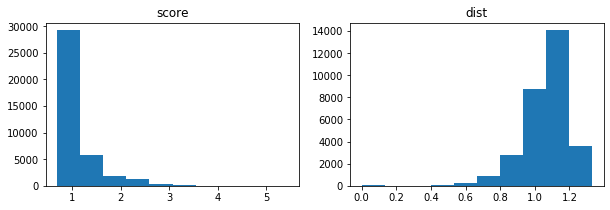

In [26]:
# plot the distribution of eventStrength & distance between contents
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.hist(np.hstack(df_answer['score'].values))
ax1.set_title('score')
ax2.hist(relevant_content_dist.flatten())
ax2.set_title('dist')
plt.show()

In [27]:
# flatten df_answer['score'] and normalize it
#=============your works starts===============#
norm_scores = normalize([np.hstack(df_answer['score'].values)])[0]
#==============your works ends================#

norm_scores_reshaped = []
st = 0
for temp_scores in df_answer['score']:
    sc_len = len(temp_scores)
    norm_scores_reshaped.append(norm_scores[st:st+sc_len])
    st += sc_len
df_answer['score_norm'] = norm_scores_reshaped
df_answer['score_norm']

0       [0.009960013500643086, 0.007295578022217593, 0...
1       [0.008484874575303909, 0.007295578022217593, 0...
2       [0.0062840688635291304, 0.004980006750321543, ...
3       [0.007295578022217593, 0.0031420344317645652, ...
4       [0.0062840688635291304, 0.004980006750321543, ...
                              ...                        
1036    [0.012121909123784153, 0.011797985819200062, 0...
1037    [0.00970091455400222, 0.004980006750321543, 0....
1038    [0.01043761245398216, 0.007295578022217593, 0....
1039    [0.008122041182086107, 0.0062840688635291304, ...
1040    [0.014406110045615239, 0.013579646885746723, 0...
Name: score_norm, Length: 1041, dtype: object

In [28]:
# flatten relevant_content_dist and normalize it
# flip the dist tribution
# reshape it into original shape
#=============your works starts===============#
norm_dist = normalize([relevant_content_dist.flatten()])[0]
norm_similarity = np.abs(norm_dist - norm_dist.max())
norm_similarity = norm_similarity.reshape(relevant_content_dist.shape)
#==============your works ends================#

df_articles['most_relevant_sim_norm'] = norm_similarity.tolist()
df_articles['most_relevant_sim_norm']

1       [0.004935502498847526, 0.003570171392772862, 0...
2       [0.00048173671350769474, 0.0004351112116075667...
3       [0.001622172385115448, 0.001579011433381872, 0...
4       [0.002315721908570519, 0.002277045755736895, 0...
5       [0.0019743462587111732, 0.0018242180908881528,...
                              ...                        
3117    [0.002156911937593052, 0.0019140450568990311, ...
3118    [0.0007869960547106578, 0.0007595436329627453,...
3119    [0.0012388656567615267, 0.0009150288586831168,...
3120    [0.0014349736085692887, 0.0011079542435466728,...
3121    [0.0006905918585841751, 0.0004968450256343099,...
Name: most_relevant_sim_norm, Length: 3047, dtype: object

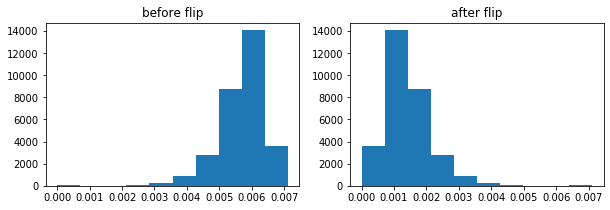

In [29]:
# see the flip result
norm_dist = normalize([relevant_content_dist.flatten()])[0]
norm_similarity = np.abs(norm_dist - norm_dist.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.hist(norm_dist)
ax1.set_title('before flip')
ax2.hist(norm_similarity)
ax2.set_title('after flip')
plt.show()

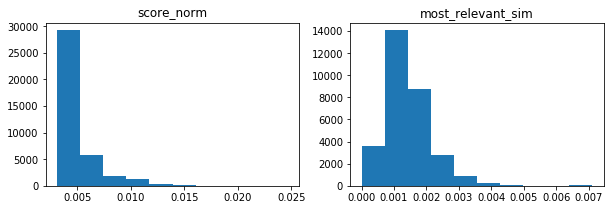

In [30]:
# plot the distribution of eventStrength & distance between contents
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.hist(np.hstack(df_answer['score_norm'].values))
ax1.set_title('score_norm')
ax2.hist(np.hstack(df_articles['most_relevant_sim_norm']))
ax2.set_title('most_relevant_sim')
plt.show()

In [31]:
content_ids_recommended_list = []
for idx, row in df_answer.iloc[:].iterrows():
    top_5_order_idx = np.where(np.isin(row['contentId'], df_articles['contentId']))[0]
    content_ids = np.array(row['contentId'])[top_5_order_idx]
    scores = np.array(row['score_norm'])[top_5_order_idx]
    
    content_ids_relevant_all = []
    content_scores_relevants_all = []
    for content_id_temp, score_temp in zip(content_ids, scores):
        # df_articles_temp: find the row in the df_articles whose contentId == content_id_temp
        # content_ids_relevant: find the most relevant content_ids in the row 
        # content_dist_relevant: find content_ids_relevant's distance (note use the normalized distance)
        # content_scores_relevant: calculate the final score by (content_dist_relevant * score_temp)
        #=============your works starts===============#
        df_articles_temp = df_articles[df_articles['contentId'] == content_id_temp].iloc[0]
        content_ids_relevant = df_articles_temp['most_relevant']
        content_sim_relevant = df_articles_temp['most_relevant_sim_norm']
        content_scores_relevant = np.array(content_sim_relevant) * score_temp * 10000
        #==============your works ends================#

        content_ids_relevant_all.extend(content_ids_relevant)
        content_scores_relevants_all.extend(content_scores_relevant)
        
    # find the most recommended content for the user
    # content_order_ids_recommended: use argsort to find the oder index of the conetent with highest score
    # content_ids_recommended: find the content_if for each order index
    #=============your works starts===============#
    content_order_ids_recommended = np.argsort(content_scores_relevants_all)[::-1][:50]
    content_ids_recommended = np.array(content_ids_relevant_all)[content_order_ids_recommended]
    #==============your works ends================#
    
    content_ids_recommended_list.append(content_ids_recommended)

df_answer['content_recommend'] = content_ids_recommended_list

In [32]:
def precision_at_k(row, k=10):
    # 計算每一個row的precision_at_k
    #=============your works starts===============#
    precision = len(set(row['content_recommend'][:k]) & set(row['contentId'])) / k
    #==============your works ends================#
    return precision

evaluation_result = df_answer.apply(precision_at_k, axis=1)
print("Average Precision At K:", np.average(evaluation_result))
# Average Precision At K: 0.08511873350923484

Average Precision At K: 0.07473583093179637


In [33]:
def recall_at_k(row, k=10):
    # 計算每一個row的recall_at_k
    #=============your works starts===============#
    recall = len(set(row['content_recommend'][:k]) & set(row['contentId'])) / len(row['contentId'])
    #==============your works ends================#
    return recall

evaluation_result = df_answer.apply(recall_at_k, axis=1)
print("Average Recall At K:", np.average(evaluation_result))
# Average Recall At K: 0.08730221807976521

Average Recall At K: 0.028314901243690575


In [34]:
%%time
precisions_popularity = []
recalls_popularity = []
for k in np.arange(1, 50):
    # 找出k個retrieved結果下的precision並append到precisions中
    # 找出k個retrieved結果下的recall並append到recalls中
    #=============your works starts===============#
    p_avg = df_answer.apply(precision_at_k, axis=1, k=k).mean()
    r_avg = df_answer.apply(recall_at_k, axis=1, k=k).mean()
    precisions_popularity.append(p_avg)
    recalls_popularity.append(r_avg)
    #==============your works ends================#

print(precisions_popularity[:5])
print(recalls_popularity[:5])
# [0.14142480211081795, 0.12163588390501319, 0.1150395778364116, 0.1054089709762533, 0.09931398416886543]
# [0.023556124542213237, 0.034394715562071, 0.043386947980631974, 0.04921683202394738, 0.05832411771369351]

[0.1585014409221902, 0.12007684918347743, 0.10310598783221261, 0.09317963496637849, 0.0878001921229587]
[0.007248992301101345, 0.010274318321552312, 0.01214875652698748, 0.014278499314263208, 0.016664217757038264]
Wall time: 5.32 s


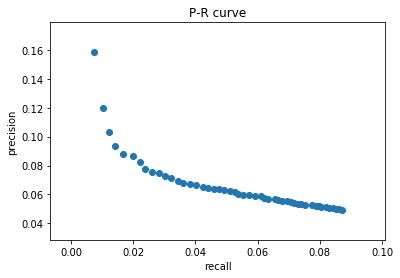

In [35]:
plt.scatter(recalls_popularity, precisions_popularity)
plt.title('P-R curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [34]:
# article id
item_ids = df_articles['contentId'].tolist()
item_ids_set = set(item_ids)

def get_user_vector(like_content_list):
    # 找出like_content_list中每一篇文章所在的位置idx
    #=============your works starts===============#
    idxs = [item_ids.index(i) for i in like_content_list if i in item_ids_set]
    #==============your works ends================#
    if len(idxs) == 0:
        # 初始劃一條全部為零，與tfidf_matrix中每一條向量等長的np.array()
        #=============your works starts===============#
        average_vector = np.zeros(tfidf_matrix.shape[1])
        #==============your works ends================#
    else:
        # 使用idxs找出tfidf_matrix中的對應向量
        # 並element-wise的計算每一條向量中每個元素的平均值(axis=0)
        #=============your works starts===============#
        tfidf_vectors = tfidf_matrix[idxs].toarray()
        average_vector = np.average(tfidf_vectors, axis=0)
        #==============your works ends================#
    return average_vector

df_answer['preference_vector'] = df_answer['contentId'].apply(get_user_vector)
df_answer['preference_vector'].head(5)
# 0    [0.002215745405614616, 0.0030089016793024893, ...
# 1    [0.0, 0.012489418801235969, 0.0, 0.0, 0.003228...
# 2    [0.013707054489011659, 0.0020078374794908756, ...
# 3    [0.0, 0.006133107865163184, 0.0, 0.0, 0.003888...
# 4    [0.0, 0.0, 0.0, 0.0, 0.018891626761135934, 0.0...
# Name: preference_vector, dtype: object

0    [0.00427858044290822, 0.008152700960562862, 0....
1    [0.022169005146048793, 0.003603753023299823, 0...
2    [0.004747213335762876, 0.0025741093023570164, ...
3    [0.009326442204514505, 0.00703132679892379, 0....
4    [0.0, 0.024895182152443077, 0.0, 0.01286908743...
Name: preference_vector, dtype: object

In [35]:
# 使用cosine_similarity去計算每一個preference_vector與每一篇待選文章的cosine similarity
#=============your works starts===============#
user_preference_vectors = np.hstack(df_answer['preference_vector'].values).reshape(-1, len(df_answer['preference_vector'].iloc[0]))
similarity_metric = cosine_similarity(user_preference_vectors, tfidf_matrix)
#==============your works ends================#
#請特別注意:
# 每一個row是使用者對每一篇文章的similarity(preference)
# 所以接下來要篩出，每一個row當中similarity最高分的10篇文章

print(similarity_metric.shape)
# (1895, 3047)
similarity_metric[:5, :5]
# array([[0.11906298, 0.10576356, 0.23490161, 0.16308151, 0.14992823],
#        [0.03358471, 0.03448321, 0.13672524, 0.04660727, 0.04195372],
#        [0.04197812, 0.03863454, 0.04912078, 0.08057892, 0.02526139],
#        [0.08572221, 0.0880551 , 0.10085452, 0.13203768, 0.08862588],
#        [0.0424938 , 0.01100553, 0.01393111, 0.0539832 , 0.04202164]])

(1140, 3047)


array([[0.12706623, 0.15449607, 0.31138374, 0.18253967, 0.16527665],
       [0.04944658, 0.07443181, 0.2396606 , 0.07097408, 0.07500188],
       [0.05983588, 0.08094475, 0.08319087, 0.12154638, 0.03081141],
       [0.10987035, 0.1359541 , 0.13764389, 0.17149883, 0.11106254],
       [0.06782309, 0.02632326, 0.01967577, 0.08860661, 0.07006593]])

In [36]:
# 使用np.argsort將每一個row的similarity進行排序，然後倒過來排續，篩出前500個
#=============your works starts===============#
top_content_idxs = np.argsort(similarity_metric, axis=1)[:, ::-1][:, :500]
#==============your works ends================#
# 請注意這邊的產出代表的是每一篇文章的在tfidf_matrix的idx位置
# 必須與contentId區別

top_content_idxs
# array([[ 650, 1032, 1643, ...,  237, 1034, 3018],
#        [ 977, 1023, 1601, ..., 1548, 1175, 1769],
#        [1671, 1593, 1795, ..., 2477, 1117, 1520],
#        ...,
#        [1622, 1845, 3021, ...,  974, 1035, 1607],
#        [1185, 1636, 1116, ..., 2309, 2357, 2616],
#        [2664, 2781,  659, ..., 2634, 1552, 3018]], dtype=int64)

array([[ 650, 1402, 1032, ...,  293,  282,  152],
       [ 977, 1023, 1601, ..., 1257,  742, 1034],
       [1671, 1593, 1601, ...,  761,  320, 2872],
       ...,
       [1622, 1845, 1682, ..., 2975,  888, 2895],
       [1636, 1185, 1307, ...,  905, 1661, 1764],
       [2993,  659, 2781, ..., 2646,  146, 2505]], dtype=int64)

In [38]:
# 將tfidf_matrix的idx轉換成contentId
#=============your works starts===============#
top_contentId = np.array([np.array(item_ids)[top_content_idx] for top_content_idx in top_content_idxs])
#==============your works ends================#

top_contentId[:5, :3]
# array([[ 8596997246990922861,  2858969450431709251, -4541461982704074404],
#        [-1995591062742965408,  6852597772196653540,  -969155230116728853],
#        [-1297580205670251233, -9216926795620865886, -4434534460030275781],
#        [-1755875383603052680,  5293701842202310496,  5037403311832115000],
#        [ 9175693555063886126,  7013665235990336340, -2069509552243850466]],
#       dtype=int64)

array([[ 8596997246990922861, -4338308747999225618,  2858969450431709251],
       [-1995591062742965408,  6852597772196653540,  -969155230116728853],
       [-1297580205670251233, -9216926795620865886,  -969155230116728853],
       [ 5293701842202310496, -1755875383603052680,  5037403311832115000],
       [ 3268064929368559554,  9175693555063886126,  7013665235990336340]],
      dtype=int64)

In [40]:
# 將top_contentId指派回df_answer['content_based_recommended']
#=============your works starts===============#
df_answer['content_based_recommended'] = list(top_contentId)
#==============your works ends================#

np.array(df_answer['content_based_recommended'].tolist())[:3, :3]
# array([[ 8596997246990922861, -4338308747999225618, -6859363289291329827],
#        [-3620251618670158123,  -969155230116728853, -1995591062742965408],
#        [ -969155230116728853, -9216926795620865886, -1297580205670251233]],
#       dtype=int64)

In [41]:
def precision_at_k(row, k=10):
    # 計算每一個row的precision_at_k
    #=============your works starts===============#
    precision = len(set(row['content_based_recommended'][:k]) & set(row['contentId'])) / k
    #==============your works ends================#
    return precision

evaluation_result = df_answer.apply(precision_at_k, axis=1)
print("Average Precision At K:", np.average(evaluation_result))
# Average Precision At K: 0.4271240105540897

Average Precision At K: 0.34578947368421054


In [42]:
def recall_at_k(row, k=10):
    # 計算每一個row的recall_at_k
    #=============your works starts===============#
    precision = len(set(row['content_based_recommended'][:k]) & set(row['contentId'])) / len(row['contentId'])
    #==============your works ends================#
    return precision

evaluation_result = df_answer.apply(recall_at_k, axis=1)
print("Average Recall At K:", np.average(evaluation_result))
# Average Recall At K: 0.7014372644445073

Average Recall At K: 0.327484791590816


In [63]:
precisions_content_based = []
recalls_content_based = []
for k in range(1, 500):
    # 找出k個retrieved結果下的precision並append到precisions中
    # 找出k個retrieved結果下的recall並append到recalls中
    #=============your works starts===============#
    p_avg = np.average(df_answer.apply(precision_at_k, axis=1, k=k))
    r_avg = np.average(df_answer.apply(recall_at_k, axis=1, k=k))
    precisions_content_based.append(p_avg)
    recalls_content_based.append(r_avg)
    #==============your works ends================#

print(precisions_content_based[:5])
print(recalls_content_based[:5])
# [0.8881266490765172, 0.8007915567282322, 0.7261213720316623, 0.662269129287599, 0.6073878627968338]
# [0.2902330255447432, 0.4325134024349371, 0.5155799081444566, 0.5702582888232454, 0.609574135903257]

[0.7850877192982456, 0.762280701754386, 0.7301169590643274, 0.7035087719298245, 0.6754385964912281]
[0.07564493170768362, 0.14901660570186542, 0.21489823153777501, 0.2767146821367931, 0.332059090394859]


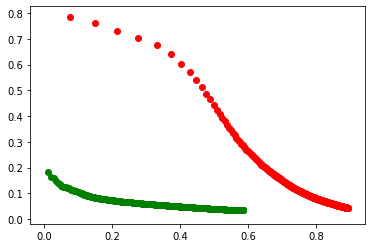

In [64]:
plt.scatter(recalls_popularity, precisions_popularity, c='g')
plt.scatter(recalls_content_based, precisions_content_based, c='r')
plt.show()

# Supervised Learning

In [43]:
df_merge = pd.merge(df_interactions_full, df_answer[['personId', 'preference_vector']], on='personId')
df_merge = pd.merge(df_merge, df_articles[['contentId', 'content_vector']], on='contentId')
df_merge

,personId,contentId,eventStrength,preference_vector,content_vector
0,-9223121837663643404,-8949113594875411859,0.693147,"[0.004815077427334156, 0.009516914497368505, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.076..."
1,-9109785559521267180,-8949113594875411859,0.693147,"[0.008115334363860666, 0.005828476762122752, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.076..."
2,-7755848049308089190,-8949113594875411859,0.693147,"[0.02614576912457781, 0.0038603653424138257, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.076..."
3,-6944500707172804068,-8949113594875411859,1.386294,"[0.009101712263772564, 0.013132111122096432, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.076..."
4,-5868110530814399805,-8949113594875411859,2.079442,"[0.012623909188155851, 0.012587783456951631, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.076..."
...,...,...,...,...,...
39074,8754745127801506293,-3113913063173722290,0.693147,"[0.00417242892472797, 0.014228434750991769, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0737348002389..."
39075,8855523843512271162,-8464215556093549753,1.098612,"[0.0053325604876029355, 0.012095310218926618, ...","[0.13165430237797324, 0.0, 0.13257009210817539..."
39076,8968131284214320024,-8202212195240926680,0.693147,"[0.011999117240986672, 0.01688334077310586, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
39077,8968131284214320024,5518462222339671372,0.693147,"[0.011999117240986672, 0.01688334077310586, 0....","[0.039744001087792705, 0.03360603238832093, 0...."


In [44]:
preference_vectors = np.array(df_merge['preference_vector'].tolist())
content_vectors = np.array(df_merge['content_vector'].tolist())

X = np.concatenate((preference_vectors, content_vectors), axis=1)
print(X.shape)

(39079, 2000)


In [53]:
preference_vectors = np.array(df_merge['preference_vector'].tolist())
content_vectors = np.array(df_merge['content_vector'].tolist())
X = np.abs(preference_vectors - content_vectors)
print(X.shape)

(39079, 1000)


In [54]:
Y = df_merge['eventStrength'].values
print(Y.shape)

(39079,)


In [55]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=1000, random_state=2019)


print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(38079, 1000)
(38079,)
(1000, 1000)
(1000,)


In [56]:
%%time

params = {}
# Set our parameters for xgboost
#=============your works starts===============#
params['objective'] = 'reg:squarederror'
params['eval_metric'] = 'rmse'
params['eta'] = 0.1
params['max_depth'] = 5
#==============your works ends================#

d_train = xgboost.DMatrix(X_train, label=Y_train)
d_valid = xgboost.DMatrix(X_valid, label=Y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgboost.train(params, d_train, 100, watchlist, early_stopping_rounds=10, verbose_eval=10)

y_pred = bst.predict(xgboost.DMatrix(X_valid))


[0]	train-rmse:0.661851	valid-rmse:0.660201
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 10 rounds.
[10]	train-rmse:0.47864	valid-rmse:0.473624
[20]	train-rmse:0.443419	valid-rmse:0.441673
[30]	train-rmse:0.432767	valid-rmse:0.434033
[40]	train-rmse:0.426214	valid-rmse:0.431199
[50]	train-rmse:0.42182	valid-rmse:0.429404
[60]	train-rmse:0.417956	valid-rmse:0.428516
[70]	train-rmse:0.414279	valid-rmse:0.427688
[80]	train-rmse:0.410272	valid-rmse:0.426268
[90]	train-rmse:0.407419	valid-rmse:0.425518
[99]	train-rmse:0.404612	valid-rmse:0.425228
Wall time: 1min 23s


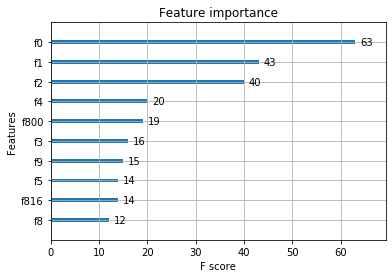

In [57]:
# 請使用 xgboost.plot_importance，並設定max_num_features=10
#!=============your works starts===============!#
xgboost.plot_importance(bst, max_num_features=10)
#!==============your works ends================!#

plt.show()

In [58]:
df_result = pd.DataFrame()

# 1. 使用X_valid去評價此模型
# 2. 使用 ['predict', 'truth', 'error'] 三個欄位的DataFrame去使決畫呈現預測結果
#    (1). 請注意與測結果(Y_pred)與真實值(Y_valid)都必須取exp方能反映實際情況
#    (2). error 請使用計算np.abs(predict-truth)/truth計算誤差百分比
# 3. 使用truth欄位排序dataframe rows
#=============your works starts===============#
Y_pred = bst.predict(xgboost.DMatrix(X_valid))
df_result['predict'] = Y_pred
df_result['truth'] = Y_valid
df_result['error'] = np.abs(Y_pred - Y_valid) / Y_valid
df_result_sort = df_result.sort_values('truth')
#==============your works ends================#

df_result_sort.head()

,predict,truth,error
0,0.996123,0.693147,0.437101
919,0.770050,0.693147,0.110948
517,1.070286,0.693147,0.544096
518,1.039991,0.693147,0.500389
519,0.851566,0.693147,0.228550


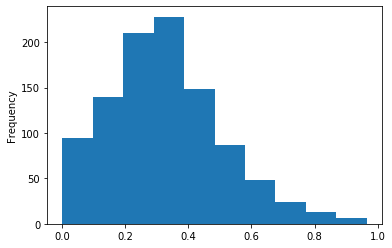

In [59]:
# 請使用df_result_sort濾掉error大於1的部分畫出error的分布圖
#!=============your works starts===============!#
df_result_sort.loc[df_result_sort['error'] < 1, 'error'].plot('hist')
#!==============your works ends================!#

plt.show()

No handles with labels found to put in legend.


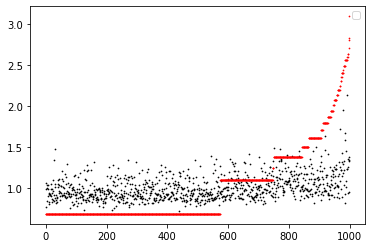

In [60]:
# 請使用plt.scatter，以0~len(df_result)作為x，預測值(黑色)與實際值(紅色)作為y。
#!=============your works starts===============!#
plt.scatter(range(len(df_result)), df_result_sort['predict'].values, color='black', s=0.5)
plt.scatter(range(len(df_result)), df_result_sort['truth'].values, color='red', s=0.5)
#!==============your works ends================!#

plt.legend()
plt.show()